In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
# Assuming we have the comoR functions implemented in Python
# For now, we'll create dummy data for fit_como.data_loglik


import os
import sys
sys.path.append(r"D:\Document\Serieux\Travail\python_work\cEBNM_torch\py")
# Import utils.py directly
from utils import *
from numerical_routine import *
from distribution_operation import *
from posterior_computation import *
# Set random seed for reproducibility
np.random.seed(1)
torch.manual_seed(1)
num_classes = 20


ImportError: 

IMPORTANT: PLEASE READ THIS FOR ADVICE ON HOW TO SOLVE THIS ISSUE!

Importing the numpy C-extensions failed. This error can happen for
many reasons, often due to issues with your setup or how NumPy was
installed.

We have compiled some common reasons and troubleshooting tips at:

    https://numpy.org/devdocs/user/troubleshooting-importerror.html

Please note and check the following:

  * The Python version is: Python3.10 from "c:\Users\WD\anaconda3\envs\torch_env\python.exe"
  * The NumPy version is: "2.0.1"

and make sure that they are the versions you expect.
Please carefully study the documentation linked above for further help.

Original error was: DLL load failed while importing _multiarray_umath: The specified module could not be found.


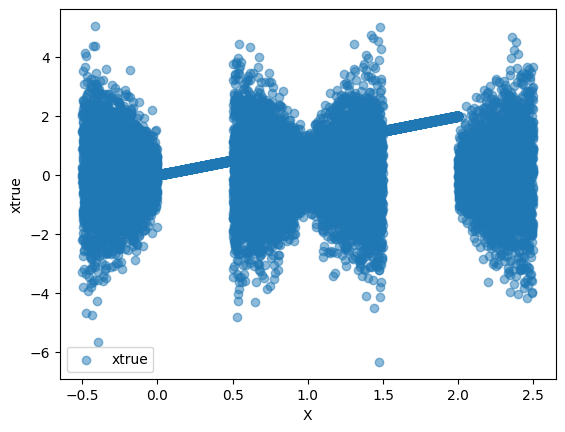

In [27]:
# Generate synthetic data
n_samples = 20000
x = np.random.uniform(-0.5, 2.5, n_samples)
X = x.reshape(-1, 1)
betatrue = np.zeros_like(x)

# Generate xtrue based on the conditional logic
for i in range(len(betatrue)):
    if (0 < x[i] < 0.5) or (1.5 < x[i] < 2):
        betatrue[i] = x[i]
    else:
        betatrue[i] = np.random.normal(0, scale=0.5 + 1 * abs(np.sin(np.pi * x[i])))

# Generate observed data x
betahat = betatrue + np.random.normal(0, 1, len(betatrue))
s = np.ones_like(x)
plt.scatter(x, betatrue,  alpha=0.5, label='xtrue')
plt.xlabel("X")
plt.ylabel("xtrue")
plt.legend()
plt.show()

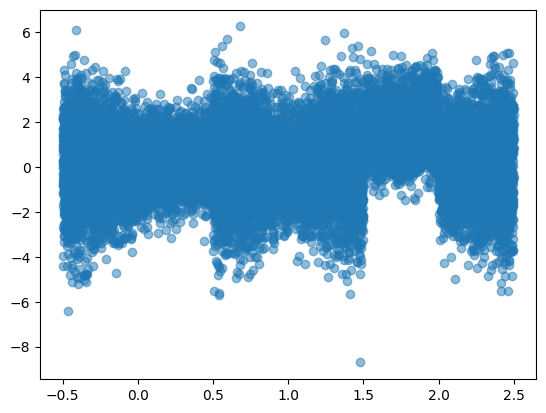

In [28]:
plt.scatter(x, betahat,  alpha=0.5, label='xtrue')

In [29]:
betahat

array([-0.51724531,  1.50576486,  1.3983601 , ...,  2.59002677,
        0.75874759,  1.15129634])

In [30]:
scale = autoselect_scales_mix_norm(betahat=betahat,
                                   sebetahat=np.full(x.shape[0],1),
                                       max_class=num_classes ) 

num_classes= scale.shape[0]
print( (scale) )
print(scale.shape)


fit_como_data_loglik = get_data_loglik_normal(betahat=betahat,
                                              sebetahat=np.full(X.shape[0],1),
                                              location=0*scale,
                                              scale=scale)
# Convert data to PyTorch tensors
y_tensor = torch.tensor(betahat, dtype=torch.float32).unsqueeze(1)  # Input (y)
x_tensor = torch.FloatTensor(x).reshape(-1, 1) 

# Create a dataset and dataloader
dataset = TensorDataset(y_tensor, x_tensor)
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

[ 0.          0.91027759  1.82055518  2.73083278  3.64111037  4.55138796
  5.46166555  6.37194314  7.28222073  8.19249833  9.10277592 10.01305351
 10.9233311  11.83360869 12.74388629 13.65416388 14.56444147 15.47471906
 16.38499665 17.29527425]
(20,)


In [31]:

# Define the MeanNet model
class MeanNet(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MeanNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Define the CashNet model
class CashNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(CashNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.softmax(self.fc4(x))
        return x

# Custom loss function
def custom_loss(pred_pi, marginal_log_lik, penalty=1.1, epsilon=1e-10):
    L_batch = torch.exp(marginal_log_lik)
    inner_sum = torch.sum(pred_pi * L_batch, dim=1)
    inner_sum = torch.clamp(inner_sum, min=epsilon)
    first_sum = torch.sum(torch.log(inner_sum))

    if penalty > 1:
        pi_clamped = torch.clamp(torch.sum(pred_pi[:, 0]), min=epsilon)
        penalized_log_likelihood_value = first_sum + (penalty - 1) * torch.log(pi_clamped)
    else:
        penalized_log_likelihood_value = first_sum

    return -penalized_log_likelihood_value


In [33]:
# Initialize models and optimizers
model_mean = MeanNet(1, 64)
model_cash = CashNet(1, 64, num_classes=20)
mean_criterion = nn.MSELoss()
optimizer_mean = optim.Adam(model_mean.parameters(), lr=0.001)
optimizer_cash = optim.Adam(model_cash.parameters(), lr=0.001)

# Training loop
n_epochs = 50
for epoch in range(n_epochs):
    total_mean_loss = 0
    total_cash_loss = 0

    for y_batch, x_batch in dataloader:
        # Train MeanNet
        optimizer_mean.zero_grad()
        mean_predictions = model_mean(x_batch)
        mean_loss = mean_criterion(mean_predictions, y_batch)
        mean_loss.backward()
        optimizer_mean.step()
        total_mean_loss += mean_loss.item()
 
        optimizer_cash.zero_grad()
        outputs = model_cash(x_batch) 

        batch_loglik = get_data_loglik_normal(betahat=y_batch-mean_predictions.detach().numpy(),
                                              sebetahat=np.full(x_batch.shape[0],1),
                                              location=0*scale,
                                              scale=scale)

        # Train variance model 
        optimizer_cash.zero_grad()
        outputs = model_cash(x_batch)
        
        cash_loss = custom_loss(pred_pi=  outputs, 
                                 marginal_log_lik=  torch.tensor(batch_loglik))


        cash_loss.backward()
        optimizer_cash.step()
        total_cash_loss += cash_loss.item()

    print(f"Epoch {epoch+1}/{n_epochs}, Mean Loss: {total_mean_loss / len(dataloader):.4f}, Variance Loss: {total_cash_loss / len(dataloader):.4f}")




C:\Users\WD\AppData\Local\Temp\ipykernel_21340\3396299041.py:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  batch_loglik = get_data_loglik_normal(betahat=y_batch-mean_predictions.detach().numpy(),


Epoch 1/50, Mean Loss: 2.2634, Variance Loss: 191.6529
Epoch 2/50, Mean Loss: 2.0892, Variance Loss: 177.6914
Epoch 3/50, Mean Loss: 2.0545, Variance Loss: 176.3575
Epoch 4/50, Mean Loss: 2.0298, Variance Loss: 175.5487
Epoch 5/50, Mean Loss: 2.0251, Variance Loss: 175.2371
Epoch 6/50, Mean Loss: 2.0201, Variance Loss: 174.8402
Epoch 7/50, Mean Loss: 2.0134, Variance Loss: 174.2037
Epoch 8/50, Mean Loss: 2.0120, Variance Loss: 173.7815
Epoch 9/50, Mean Loss: 2.0043, Variance Loss: 173.3736
Epoch 10/50, Mean Loss: 2.0043, Variance Loss: 173.2983
Epoch 11/50, Mean Loss: 2.0038, Variance Loss: 173.1711
Epoch 12/50, Mean Loss: 1.9972, Variance Loss: 172.8469
Epoch 13/50, Mean Loss: 1.9980, Variance Loss: 172.7487
Epoch 14/50, Mean Loss: 1.9923, Variance Loss: 172.5584
Epoch 15/50, Mean Loss: 1.9976, Variance Loss: 172.6403
Epoch 16/50, Mean Loss: 1.9921, Variance Loss: 172.5496
Epoch 17/50, Mean Loss: 1.9974, Variance Loss: 172.5408
Epoch 18/50, Mean Loss: 1.9889, Variance Loss: 172.2520
E

In [25]:
print(y_batch)
print(np.full(x_batch.shape[0],1))
#print(mean_predictions.detach().numpy())
#print(scale)

tensor([[ 1.0120e+00],
        [ 2.6547e-01],
        [-3.3905e-01],
        [-2.5658e+00],
        [ 4.9657e-01],
        [ 1.3883e+00],
        [-1.5191e-01],
        [ 1.6283e+00],
        [-8.7544e-01],
        [ 1.3707e+00],
        [ 1.0159e+00],
        [-2.3936e+00],
        [-9.3892e-01],
        [ 1.7958e+00],
        [ 7.0597e-01],
        [ 2.0035e-01],
        [-3.1057e-01],
        [-2.2262e+00],
        [ 1.7155e-01],
        [-1.4999e+00],
        [ 4.9518e-01],
        [ 1.1659e+00],
        [-2.3033e-01],
        [-2.3847e+00],
        [ 2.8302e-02],
        [ 1.6189e+00],
        [-1.1407e-02],
        [-5.1074e-01],
        [ 2.0820e+00],
        [-3.1558e-01],
        [ 5.0010e-01],
        [ 9.5272e-01],
        [ 3.0854e+00],
        [ 1.9024e+00],
        [ 1.3108e-01],
        [ 2.3508e-03],
        [ 2.8411e-01],
        [ 1.5418e+00],
        [ 2.2325e+00],
        [ 4.6437e-01],
        [-5.7950e-01],
        [-5.2902e-01],
        [-1.5913e+00],
        [ 2

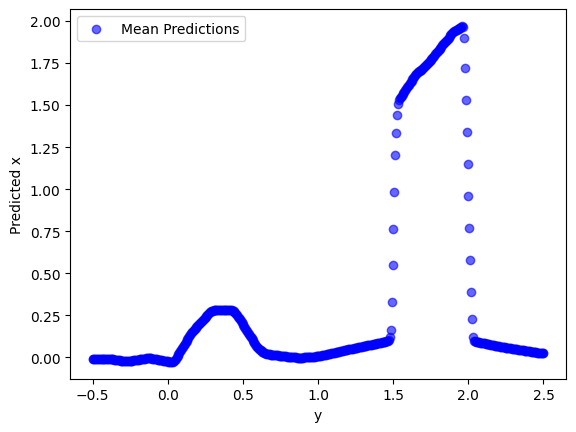

In [34]:
# Evaluate models
model_mean.eval()
y_test = np.linspace(-0.5, 2.5, 500).reshape(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
mean_test_predictions = model_mean(y_test_tensor).detach().numpy()

plt.scatter(y_test, mean_test_predictions, label='Mean Predictions', color='blue', alpha=0.6)
plt.xlabel("y")
plt.ylabel("Predicted x")
plt.legend()
plt.show()

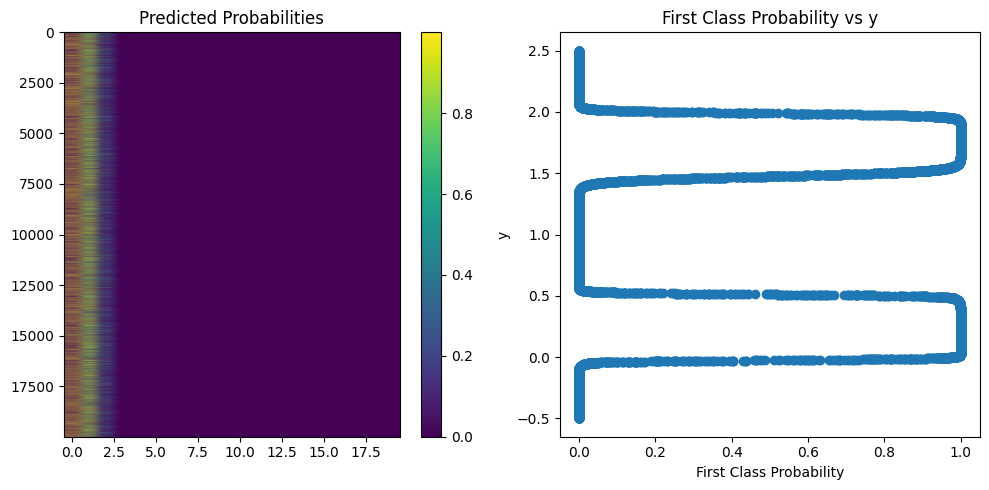

In [35]:
# Predict
model_cash.eval()
with torch.no_grad():
    tt1 = model_cash(x_tensor).numpy()

 
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(tt1, aspect='auto')
plt.title('Predicted Probabilities')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(tt1[:, 0], x )
plt.title('First Class Probability vs y')
plt.xlabel('First Class Probability')
plt.ylabel('y')

plt.tight_layout()
plt.show()
 

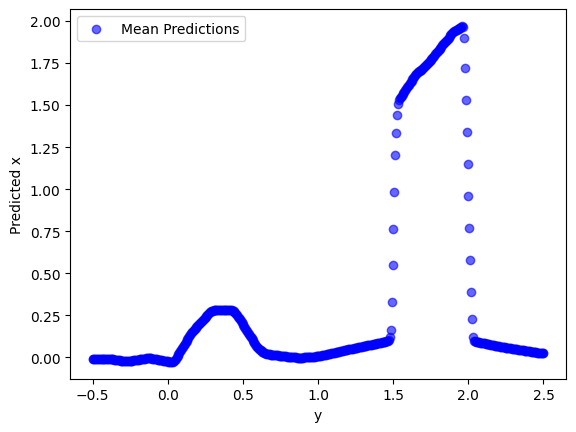

In [36]:
# Evaluate models
model_mean.eval()
y_test = np.linspace(-0.5, 2.5, 500).reshape(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
mean_test_predictions = model_mean(y_test_tensor).detach().numpy()

plt.scatter(y_test, mean_test_predictions, label='Mean Predictions', color='blue', alpha=0.6)
plt.xlabel("y")
plt.ylabel("Predicted x")
plt.legend()
plt.show()

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from posterior_computation import posterior_mean_norm  # Ensure this import works

# [Previous code for data generation and model definition remains the same]

# After training the model, compute the posterior mean
model_mean.eval()
model_cash.eval()
with torch.no_grad():
    all_pi_values = model_cash(x_tensor)
    all_location  = model_mean(x_tensor)

all_pi_values_np = all_pi_values.numpy()
all_location  =  all_location.numpy()
 

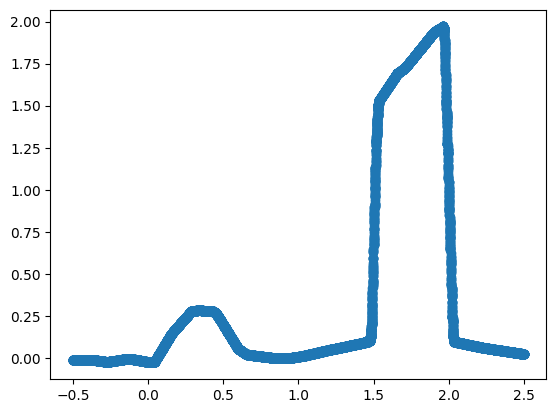

In [ ]:
plt.scatter(X,all_location)

In [40]:
i=3
print(all_pi_values_np[2, :] )
print (sum(all_pi_values_np[2, :]  ))


print(scale[2])
est_post = np.zeros(n_samples)

print(posterior_mean_norm(
        betahat=np.array([betahat[i]]),
        sebetahat=np.array([s[i]]),
        log_pi=np.log(all_pi_values_np[i, :]),
        scale= scale # Assuming this is available from earlier in your code
    ).post_mean)

[1.4483376e-14 4.3940523e-01 5.6059468e-01 2.9637523e-10 1.8797838e-10
 1.5648039e-08 1.1753831e-10 3.5801945e-10 1.8856793e-11 2.5648830e-11
 8.8838355e-12 3.2156656e-12 4.4090556e-12 1.8138024e-12 2.4407702e-12
 1.6667767e-12 1.0559755e-12 1.1908963e-12 2.5998919e-12 5.8707119e-13]
0.9999999
1.820555183740492
[-0.0004572]


In [14]:
np.array([all_location[1
             ]])

array([[1.6938738]], dtype=float32)

In [41]:
est_post = np.zeros(n_samples)
for i in range(n_samples):
    est_post[i] = posterior_mean_norm(
        betahat=np.array([betahat[i]]),
        sebetahat=np.array([s[i]]),
        log_pi=np.log(all_pi_values_np[i, :]),
        location =  all_location[i],
        scale= scale  # Assuming this is available from earlier in your code
    ).post_mean


C:\Users\WD\AppData\Local\Temp\ipykernel_21340\1085030367.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  est_post[i] = posterior_mean_norm(


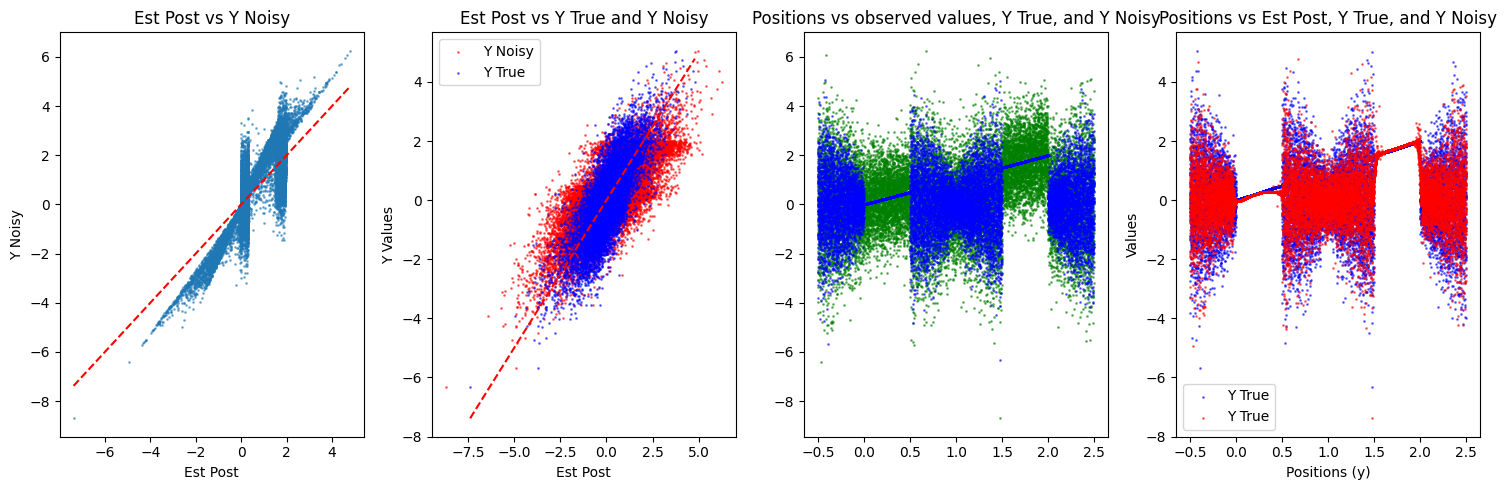


Statistics:
Est Post - Mean: 0.3383, Std: 0.9958
Y Noisy - Mean: 0.3381, Std: 1.1599


NameError: name 'xtrue' is not defined

In [42]:
# Plot results
plt.figure(figsize=(15, 5))

# Plot 1: Est Post vs Y Noisy
plt.subplot(1, 4, 1)
plt.scatter(est_post, betahat, alpha=0.5, s=1)
plt.title('Est Post vs Y Noisy')
plt.xlabel('Est Post')
plt.ylabel('Y Noisy')
plt.plot([min(est_post), max(est_post)], [min(est_post), max(est_post)], 'r--')

# Plot 2: Est Post vs Y True
plt.subplot(1, 4, 2)
plt.scatter(betahat, betatrue, alpha=0.5, s=1, label='Y Noisy', color='red')

plt.scatter(est_post, betatrue, alpha=0.5, s=1, label='Y True', color='blue')
plt.title('Est Post vs Y True and Y Noisy')
plt.xlabel('Est Post')
plt.ylabel('Y Values')
plt.legend()
plt.plot([min(est_post), max(est_post)], [min(est_post), max(est_post)], 'r--')

# Plot 3: Positions vs Est Post, Y True, and Y Noisy
plt.subplot(1, 4, 3)
#plt.scatter(y, y_n_np, alpha=0.5, s=1, label='Y Noisy', color='red')

plt.scatter(x, betahat, alpha=0.5, s=1, label='Y True', color='green')
plt.scatter(x, betatrue, alpha=0.5, s=1, label='Y True', color='blue')
#plt.scatter(y, x, alpha=0.5, s=1, label='Y True', color='green')
plt.title('Positions vs observed values, Y True, and Y Noisy')
plt.subplot(1,4,4)
plt.scatter(x, betatrue, alpha=0.5, s=1, label='Y True', color='blue')

plt.scatter(x, est_post, alpha=0.5, s=1, label='Y True', color='red')
plt.title('Positions vs Est Post, Y True, and Y Noisy')
plt.xlabel('Positions (y)')
plt.ylabel('Values')
plt.legend()

plt.tight_layout()
plt.show()

# Print some statistics
print("\nStatistics:")
print(f"Est Post - Mean: {np.mean(est_post):.4f}, Std: {np.std(est_post):.4f}")
print(f"Y Noisy - Mean: {np.mean(betahat):.4f}, Std: {np.std(betatrue):.4f}")
print(f"Y True - Mean: {np.mean(xtrue):.4f}, Std: {np.std(xtrue):.4f}")

# Calculate and print MSE
mse_noisy = np.mean((xtrue - x)**2)
mse_true = np.mean((est_post - xtrue)**2)
print(f"\nMean Squared Error:")
print(f"MSE (Est Post vs Y Noisy): {mse_noisy:.4f}")
print(f"MSE (Est Post vs Y True): {mse_true:.4f}")
